In [2]:
# Install required libraries if not already installed
# !pip install pandas numpy scikit-learn matplotlib seaborn tensorflow

# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping


In [4]:
data = pd.read_csv('creditcard.csv')

In [5]:
# Preprocess Data
data = data.drop(['Time'], axis=1)  # Drop 'Time' feature
scaler = StandardScaler()
data['Amount'] = scaler.fit_transform(data['Amount'].values.reshape(-1, 1))  # Scale 'Amount'

In [6]:
# Split Features and Target
X = data.drop('Class', axis=1)
y = data['Class']

In [7]:
# Separate Normal and Fraudulent Transactions
X_normal = X[y == 0]
X_fraud = X[y == 1]

In [8]:
# Autoencoder Architecture
input_dim = X_normal.shape[1]
input_layer = Input(shape=(input_dim,))
encoder = Dense(16, activation='relu')(input_layer)
encoder = Dense(8, activation='relu')(encoder)
encoder = Dense(4, activation='relu')(encoder)

decoder = Dense(8, activation='relu')(encoder)
decoder = Dense(16, activation='relu')(decoder)
output_layer = Dense(input_dim, activation='linear')(decoder)

In [9]:
# Compile Model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

In [11]:
# Early Stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [12]:
# Train Autoencoder on Normal Transactions
history = autoencoder.fit(
    X_normal, X_normal,
    epochs=20,
    batch_size=256,
    shuffle=True,
    validation_split=0.2,
    callbacks=[early_stop]
)

Epoch 1/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.8538 - val_loss: 0.5975
Epoch 2/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5508 - val_loss: 0.5036
Epoch 3/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5104 - val_loss: 0.4744
Epoch 4/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4778 - val_loss: 0.4537
Epoch 5/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4529 - val_loss: 0.4256
Epoch 6/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4310 - val_loss: 0.4153
Epoch 7/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4255 - val_loss: 0.4080
Epoch 8/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4179 - val_loss: 0.4015
Epoch 9/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4084 - val_loss: 0.3981
Epoch 10/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4093 - val_loss: 0.3939
Epoch 11/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4049 - val_loss: 0.3898
Epoch 12/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

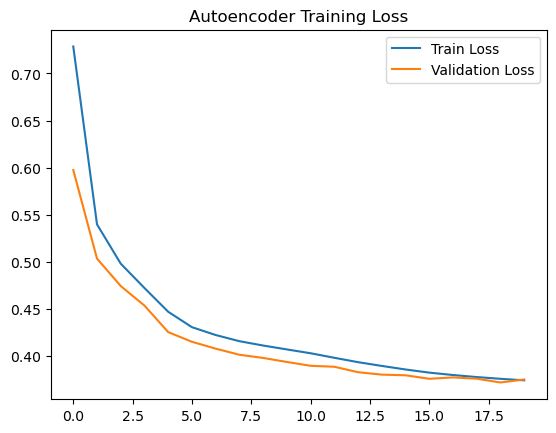

In [13]:
# Plot Training Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Autoencoder Training Loss')
plt.show()

In [14]:
# Calculate Reconstruction Error
reconstructions = autoencoder.predict(X)
mse = np.mean(np.power(X - reconstructions, 2), axis=1)

8901/8901 ━━━━━━━━━━━━━━━━━━━━ 6s 649us/step


In [15]:
# Determine Threshold for Fraud Detection
threshold = np.percentile(mse, 95)  # Top 5% as anomalies
print(f"Reconstruction Error Threshold: {threshold}")

Reconstruction Error Threshold: 0.8603199394719607


In [16]:
# Predict Frauds
y_pred = [1 if e > threshold else 0 for e in mse]


Confusion Matrix:


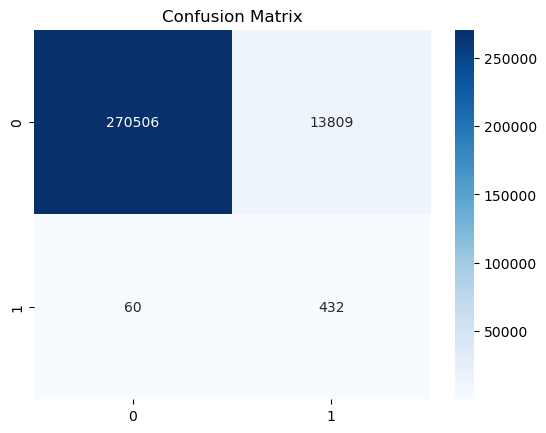


Classification Report:


              precision    recall  f1-score   support

           0       1.00      0.95      0.98    284315
           1       0.03      0.88      0.06       492

    accuracy                           0.95    284807
   macro avg       0.52      0.91      0.52    284807
weighted avg       1.00      0.95      0.97    284807

ROC AUC Score: 0.9559
Model saved as 'fraud_autoencoder_model.h5'


In [17]:
# Evaluation Metrics
print("\nConfusion Matrix:")
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(y, y_pred))

roc_score = roc_auc_score(y, mse)
print(f"ROC AUC Score: {roc_score:.4f}")

# Save Autoencoder Model
autoencoder.save('fraud_autoencoder_model.h5')
print("Model saved as 'fraud_autoencoder_model.h5'")

In [19]:
from tensorflow.keras.models import load_model

# Load the model specifying the loss function
loaded_model = load_model('fraud_autoencoder_model.h5', compile=False)

# Compile again with full loss name
loaded_model.compile(optimizer='adam', loss='mean_squared_error')

# Predict New Transaction Example
sample_transaction = X.iloc[0].values.reshape(1, -1)  # Replace with new data as needed
reconstruction = loaded_model.predict(sample_transaction)
sample_mse = np.mean(np.power(sample_transaction - reconstruction, 2))

if sample_mse > threshold:
    print("⚠️ Fraudulent Transaction Detected")
else:
    print("✅ Legitimate Transaction")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
✅ Legitimate Transaction


In [21]:
# Select a Fraudulent Sample
fraudulent_sample = X[y == 1].iloc[0].values.reshape(1, -1)  # Fraudulent

# Predict Fraudulent Transaction
reconstruction = loaded_model.predict(fraudulent_sample)
sample_mse = np.mean(np.power(fraudulent_sample - reconstruction, 2))

if sample_mse > threshold:
    print("⚠️ Fraudulent Transaction Detected")
else:
    print("✅ Legitimate Transaction")

print(f"Reconstruction Error: {sample_mse:.6f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
⚠️ Fraudulent Transaction Detected
Reconstruction Error: 2.692657


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [27]:
# Load dataset
data = pd.read_csv('creditcard.csv')

In [28]:
# Preprocess data
data.drop(['Time'], axis=1, inplace=True)
scaler = StandardScaler()
data['Amount'] = scaler.fit_transform(data[['Amount']])

X = data.drop('Class', axis=1)
y = data['Class']

In [30]:
# Autoencoder for anomaly detection
input_dim = X.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation='relu')(input_layer)
encoded = Dense(8, activation='relu')(encoded)
decoded = Dense(16, activation='relu')(encoded)
decoded = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(), loss='mse')

In [31]:
# Train autoencoder on normal transactions
X_normal = X[y == 0]
autoencoder.fit(X_normal, X_normal, epochs=5, batch_size=128, validation_split=0.2, callbacks=[EarlyStopping(patience=3)], verbose=2)

# Calculate reconstruction errors
X_reconstructed = autoencoder.predict(X)
reconstruction_error = np.mean(np.power(X - X_reconstructed, 2), axis=1)

Epoch 1/5
1777/1777 - 6s - 3ms/step - loss: 0.5384 - val_loss: 0.3648
Epoch 2/5
1777/1777 - 4s - 2ms/step - loss: 0.3272 - val_loss: 0.3110
Epoch 3/5
1777/1777 - 4s - 2ms/step - loss: 0.2943 - val_loss: 0.2804
Epoch 4/5
1777/1777 - 4s - 2ms/step - loss: 0.2746 - val_loss: 0.2650
Epoch 5/5
1777/1777 - 4s - 2ms/step - loss: 0.2646 - val_loss: 0.2590
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


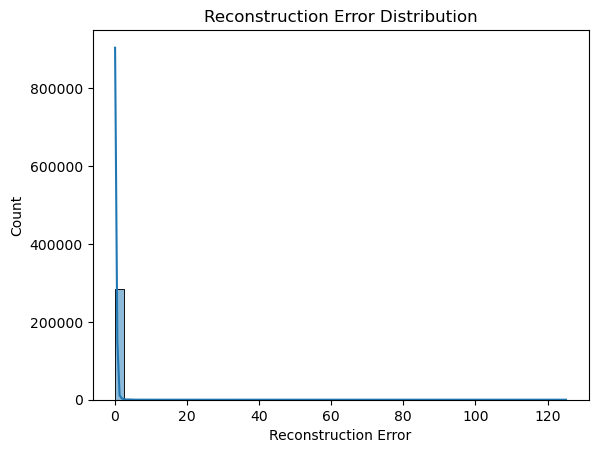

In [32]:
# Plot reconstruction error\plt.figure(figsize=(10,5))
sns.histplot(reconstruction_error, bins=50, kde=True)
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Count')
plt.show()

In [34]:
# Add error as feature
X['reconstruction_error'] = reconstruction_error

# LSTM for sequential analysis
X_seq = X.values.reshape((X.shape[0], 1, X.shape[1]))

lstm_input = Input(shape=(X_seq.shape[1], X_seq.shape[2]))
lstm_out = LSTM(64, activation='relu', return_sequences=False)(lstm_input)
lstm_out = Dense(X.shape[1], activation='linear')(lstm_out)  # Match output dimensions
lstm_model = Model(inputs=lstm_input, outputs=lstm_out)
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.fit(X_seq, X.values, epochs=3, batch_size=128, verbose=2)

Epoch 1/3
2226/2226 - 14s - 6ms/step - loss: 0.1049
Epoch 2/3
2226/2226 - 9s - 4ms/step - loss: 0.0090
Epoch 3/3
2226/2226 - 9s - 4ms/step - loss: 0.0039


In [35]:
# Extract LSTM features
lstm_features = lstm_model.predict(X_seq)

8901/8901 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step


In [36]:
# Combine features for Random Forest
X_combined = np.hstack((X.values, lstm_features))

In [37]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

In [38]:
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [39]:
# Predictions
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

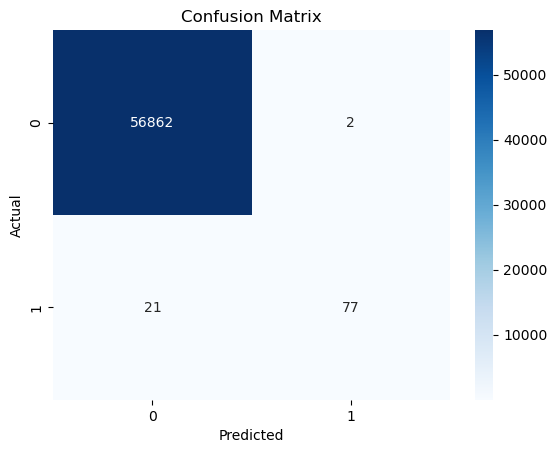

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.97      0.79      0.87        98

    accuracy                           1.00     56962
   macro avg       0.99      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC Score: 0.9576832262871383


In [40]:
# Evaluation
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

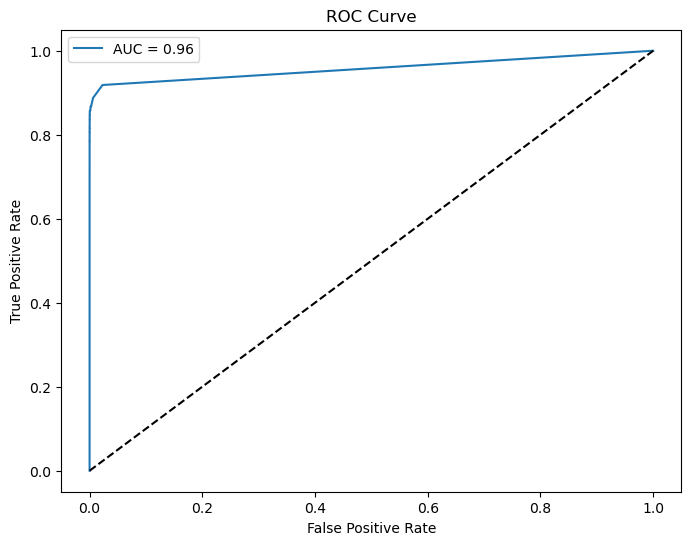

In [41]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

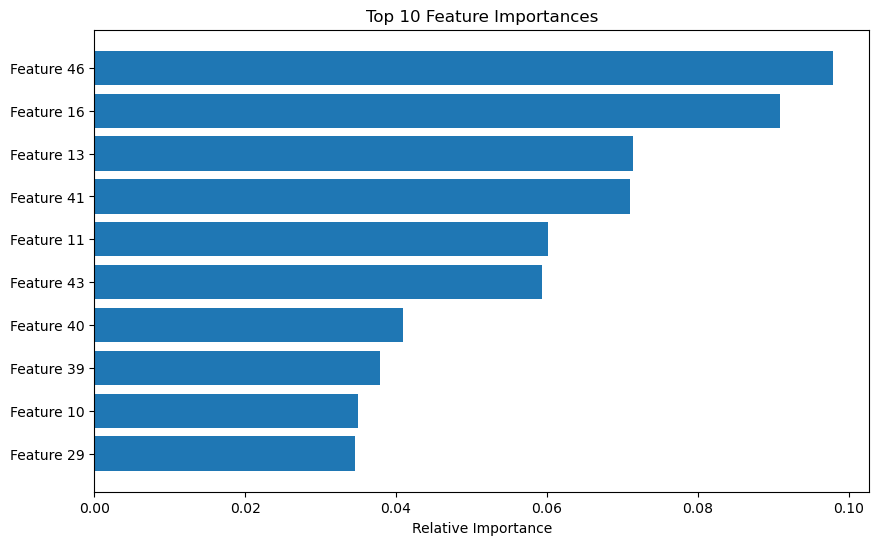

In [42]:
# Feature Importance
importances = rf.feature_importances_
indices = np.argsort(importances)[-10:]
plt.figure(figsize=(10,6))
plt.title('Top 10 Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [f'Feature {i}' for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [44]:
# Check the shape of new_transaction
print("New Transaction Shape:", new_transaction.shape)
print("Autoencoder Input Shape:", autoencoder.input_shape)

# Fix missing feature (if needed)
if new_transaction.shape[1] != autoencoder.input_shape[1]:
    diff = autoencoder.input_shape[1] - new_transaction.shape[1]
    if diff > 0:
        # Add zeros if features are missing
        new_transaction = np.pad(new_transaction, ((0, 0), (0, diff)), 'constant')
    else:
        # Trim extra features if any
        new_transaction = new_transaction[:, :autoencoder.input_shape[1]]

# Retry prediction
reconstructed = autoencoder.predict(new_transaction)
reconstruction_error = np.mean(np.power(new_transaction - reconstructed, 2))
print(f"Reconstruction Error: {reconstruction_error:.5f}")


New Transaction Shape: (1, 30)
Autoencoder Input Shape: (None, 29)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Reconstruction Error: 0.12235
